In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from bias_transfer.dataset import dataset_loader
from bias_transfer.config import *
from bias_transfer.trainer import trainer
from bias_transfer.models.resnet import resnet_builder

import os
import datajoint as dj

dj.config['database.host'] = os.environ['DJ_HOST']
dj.config['database.user'] = os.environ['DJ_USER']
dj.config['database.password'] = os.environ['DJ_PASS']
dj.config['enable_python_native_blobs'] = True
dj.config['schema_name'] = "anix_nnfabrik_bias_transfer"
# dj.config['schema_name'] = "anix_nnfabrik_bias_transfer_test"

from bias_transfer.tables.transfer import *
import nnfabrik as nnf
nnf.config['repos'] = ['/notebooks/nnfabrik']
from nnfabrik.main import *

Connecting anix@datajoint-db.mlcloud.uni-tuebingen.de:3306


In [29]:
schema.drop()

Proceed to delete entire schema `anix_nnfabrik_bias_transfer`? [yes, No]:  yes


In [2]:
fabrikant = dict(fabrikant_name="Arne Nix", email="arnenix@googlemail.com", affiliation="sinzlab", dj_username="anix")
Fabrikant().insert1(fabrikant)

In [3]:
Seed().insert1(dict(seed=42))

In [36]:
config= Config(optimizer="Adam", lr=0.1, lr_decay=0.2, num_epochs=200, add_noise=True, noise_snr={2.0:0.5, None:0.5}, apply_data_augmentation=True, apply_data_normalization=False)

In [32]:
Trainer().add_entry(trainer_fn="bias_transfer.trainer.trainer",
                        trainer_config=config.trainer,
                        trainer_fabrikant="Arne Nix",
                        trainer_comment=config.name[:256])

In [6]:
Dataset().add_entry(dataset_fn="bias_transfer.dataset.dataset_loader",
                        dataset_config=config.data,
                        dataset_fabrikant="Arne Nix",
                        dataset_comment=config.data_comment[:256])

In [7]:
Model().add_entry(model_fn="bias_transfer.models.resnet.resnet_builder",
                      model_config=config.model,
                      model_fabrikant="Arne Nix",
                      model_comment=config.model_comment[:256])

In [41]:
with_transfer = (Trainer()  & "trainer_comment LIKE '%transfer%'")
hashes_w_transfer = with_transfer.fetch("trainer_hash")

In [42]:
Trainer() & ["trainer_hash='{}'".format(h) for h in hashes_w_transfer ]

trainer_fn name of the Trainer loader function,trainer_hash hash of the configuration object,trainer_config training configuration object,trainer_fabrikant Name of the contributor that added this entry,trainer_comment short description,trainer_ts UTZ timestamp at time of insertion
bias_transfer.trainer.trainer,097547a123b6c84b7dd78daaf53012af,=BLOB=,Arne Nix,apply_data_augmentation_True.optimizer_Adam.lr_0.0003.lr_decay_0.5.transfer,2019-12-23 14:41:08
bias_transfer.trainer.trainer,4854e8635b124aa106430958845d38e1,=BLOB=,Arne Nix,apply_data_augmentation_True.optimizer_Adam.lr_0.1.lr_decay_0.2.transfer,2019-12-23 14:43:06
bias_transfer.trainer.trainer,5222b62b669b26b7ea124f1396bfd062,=BLOB=,Arne Nix,apply_data_augmentation_True.optimizer_Adam.lr_0.0003.lr_decay_0.5.transfer,2019-12-23 14:42:33
bias_transfer.trainer.trainer,563be76ce26f72e305dde54289d6b546,=BLOB=,Arne Nix,apply_data_augmentation_True.optimizer_Adam.lr_0.1.lr_decay_0.2.transfer,2019-12-23 14:43:10


In [10]:
TrainedModel().populate(["trainer_hash='{}'".format(h) for h in hashes_w_transfer], 
                        display_progress=True,reserve_jobs=True, order="random")

  0%|          | 0/1 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Building model..
==> Starting model apply_data_augmentation_True.optimizer_Adam.lr_0.0003.lr_decay_0.5.transfer


Train Epoch 0:   0%|          | 0/352 [00:00<?, ?it/s]

Is connected: True


  0%|          | 0/1 [00:25<?, ?it/s]


KeyboardInterrupt: 

In [89]:
TrainedModel()

model_fn name of the model function,model_hash hash of the model configuration,dataset_fn name of the dataset loader function,dataset_hash hash of the configuration object,trainer_fn name of the Trainer loader function,trainer_hash hash of the configuration object,seed Random seed that is passed to the model- and dataset-builder,comment short description,score loss,output trainer object's output,fabrikant_name Name of the contributor that added this entry,trainedmodel_ts UTZ timestamp at time of insertion


Object `TrainedModel().populate` not found.


In [ ]:
TrainedModel().populate

In [7]:
Trainer().fetch1("trainer_config")

{'force_cpu': False,
 'resume': False,
 'num_epochs': 1,
 'optimizer': 'Adam',
 'lr': 0.0003,
 'lr_decay': 0.5,
 'lr_milestones': (60, 120, 160),
 'add_noise': False,
 'noise_std': None,
 'noise_snr': {2.0: 0.5, None: 0.5},
 'noise_test': {'noise_snr': [{5.0: 1.0},
   {4.0: 1.0},
   {3.0: 1.0},
   {2.0: 1.0},
   {1.0: 1.0},
   {0.5: 1.0},
   {0.0: 1.0}],
  'noise_std': [{0.0: 1.0},
   {0.05: 1.0},
   {0.1: 1.0},
   {0.2: 1.0},
   {0.3: 1.0},
   {0.5: 1.0},
   {1.0: 1.0}]},
 'freeze': True,
 'reset_linear': False,
 'comment': 'apply_data_augmentation_True.optimizer_Adam.num_epochs_1.lr_0.0003.lr_decay_0.5.transfer'}

# Transfer

In [117]:
TrainedTransferModel().populate(display_progress=True, reserve_jobs=True, order="random")

In [49]:
results_ = ((TrainedTransferModel() & "NOT comment LIKE '%num_epochs%'") * Trainer * Trainer.proj(transfer_training_config_hash="training_config_hash", transfer_training_config="training_config")).fetch("training_config","transfer_training_config","output")  #transfer_training is the training after transfer

In [43]:
TrainedTransferModel()

transfer_model_fn name of the model function,transfer_model_hash hash of the model configuration,transfer_dataset_fn name of the dataset loader function,transfer_dataset_hash hash of the configuration object,transfer_trainer_fn name of the Trainer loader function,transfer_trainer_hash hash of the configuration object,transfer_seed Random seed that is passed to the model- and dataset-builder,model_fn name of the model function,model_hash hash of the model configuration,dataset_fn name of the dataset loader function,dataset_hash hash of the configuration object,trainer_fn name of the Trainer loader function,trainer_hash hash of the configuration object,seed Random seed that is passed to the model- and dataset-builder,comment short description,score loss,output trainer object's output,fabrikant_name Name of the contributor that added this entry,trainedmodel_ts UTZ timestamp at time of insertion


In [51]:
results = [r[2:6] for r in results_]
results[:2]

[array([{'force_cpu': False, 'resume': False, 'num_epochs': 200, 'optimizer': 'Adam', 'lr': 0.0003, 'lr_decay': 0.5, 'lr_milestones': (60, 120, 160), 'add_noise': False, 'noise_std': None, 'noise_snr': 0.9, 'comment': 'apply_data_augmentation_True.optimizer_Adam.lr_0.0003.lr_decay_0.5'},
        {'force_cpu': False, 'resume': False, 'num_epochs': 200, 'optimizer': 'Adam', 'lr': 0.0003, 'lr_decay': 0.5, 'lr_milestones': (60, 120, 160), 'add_noise': True, 'noise_std': None, 'noise_snr': 2.0, 'comment': 'apply_data_augmentation_True.optimizer_Adam.lr_0.0003.lr_decay_0.5.add_noise_True.noise_snr_2.0'},
        {'force_cpu': False, 'resume': False, 'num_epochs': 200, 'optimizer': 'Adam', 'lr': 0.0003, 'lr_decay': 0.5, 'lr_milestones': (60, 120, 160), 'add_noise': False, 'noise_std': None, 'noise_snr': 0.9, 'comment': 'apply_data_augmentation_True.optimizer_Adam.lr_0.0003.lr_decay_0.5'},
        {'force_cpu': False, 'resume': False, 'num_epochs': 200, 'optimizer': 'Adam', 'lr': 0.0003, 'lr_d

In [55]:
pre_clean_trans_clean_results = [r[0] for r in results][2]
pre_noisy_trans_clean_results = [r[1] for r in results][2]
pre_clean_trans_noisy_results = [r[2] for r in results][2]
pre_noisy_trans_noisy_results = [r[3] for r in results][2]

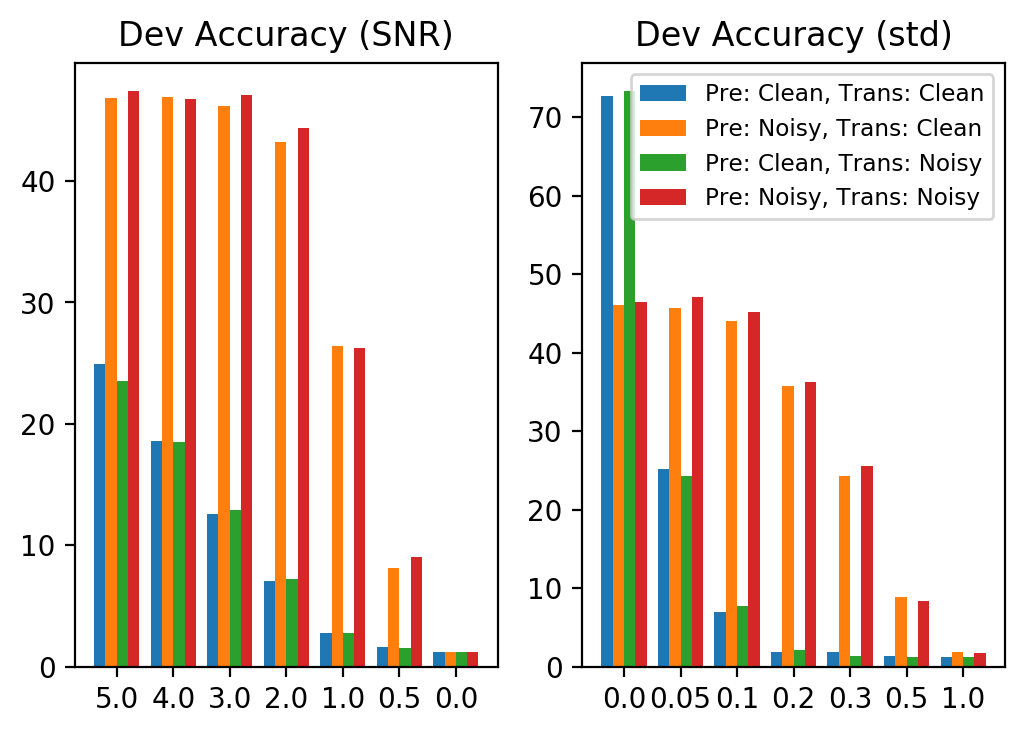

In [122]:
fig, ax = plt.subplots(1,2)
fig.set_dpi(200)
width = 0.2
ax[0].set_title('Dev Accuracy (SNR)')
D = pre_clean_trans_clean_results[-1]['dev_noise_acc']['noise_snr']
ax[0].bar(np.array(range(len(D)))- 2 * width, list(D.values()), width=width, label='Pre: Clean, Trans: Clean')
D = pre_noisy_trans_clean_results[-1]['dev_noise_acc']['noise_snr']
ax[0].bar(np.array(range(len(D)))-width, list(D.values()), width=width, label='Pre: Noisy, Trans: Clean')
D = pre_clean_trans_noisy_results[-1]['dev_noise_acc']['noise_snr']
ax[0].bar(np.array(range(len(D))), list(D.values()), width=width, label='Pre: Clean, Trans: Noisy')
D = pre_noisy_trans_noisy_results[-1]['dev_noise_acc']['noise_snr']
ax[0].bar(np.array(range(len(D)))+width, list(D.values()), width=width, label='Pre: Noisy, Trans: Noisy')
ax[0].set_xticks(np.array(range(len(D)))-0.5*width)
ax[0].set_xticklabels(list(D.keys()))

ax[1].set_title('Dev Accuracy (std)')
D = pre_clean_trans_clean_results[-1]['dev_noise_acc']['noise_std']
ax[1].bar(np.array(range(len(D)))- 2 * width, list(D.values()), width=width, label='Pre: Clean, Trans: Clean')
D = pre_noisy_trans_clean_results[-1]['dev_noise_acc']['noise_std']
ax[1].bar(np.array(range(len(D)))-width, list(D.values()), width=width, label='Pre: Noisy, Trans: Clean')
D = pre_clean_trans_noisy_results[-1]['dev_noise_acc']['noise_std']
ax[1].bar(np.array(range(len(D))), list(D.values()), width=width, label='Pre: Clean, Trans: Noisy')
D = pre_noisy_trans_noisy_results[-1]['dev_noise_acc']['noise_std']
ax[1].bar(np.array(range(len(D)))+width, list(D.values()), width=width, label='Pre: Noisy, Trans: Noisy')
ax[1].set_xticks(np.array(range(len(D)))-0.5*width)
ax[1].set_xticklabels(list(D.keys()))

ax[1].legend(fontsize='small')
fig.show()

# if noise in training: SNR 2.0

# Visualization

In [103]:
from bias_transfer.visualization import *

In [113]:
config = Config(apply_data_augmentation=True, apply_data_normalization=False, batch_size=128)

In [114]:
data_loaders, model, train_fct = nnf.builder.get_all_parts(dataset_fn=dataset_loader,
                                                               dataset_config=config.data,
                                                               trainer_fn=trainer,
                                                               trainer_config=config.trainer,
                                                               model_fn=resnet_builder,
                                                               model_config=config.model
                                                               )

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


==> Starting visualization 


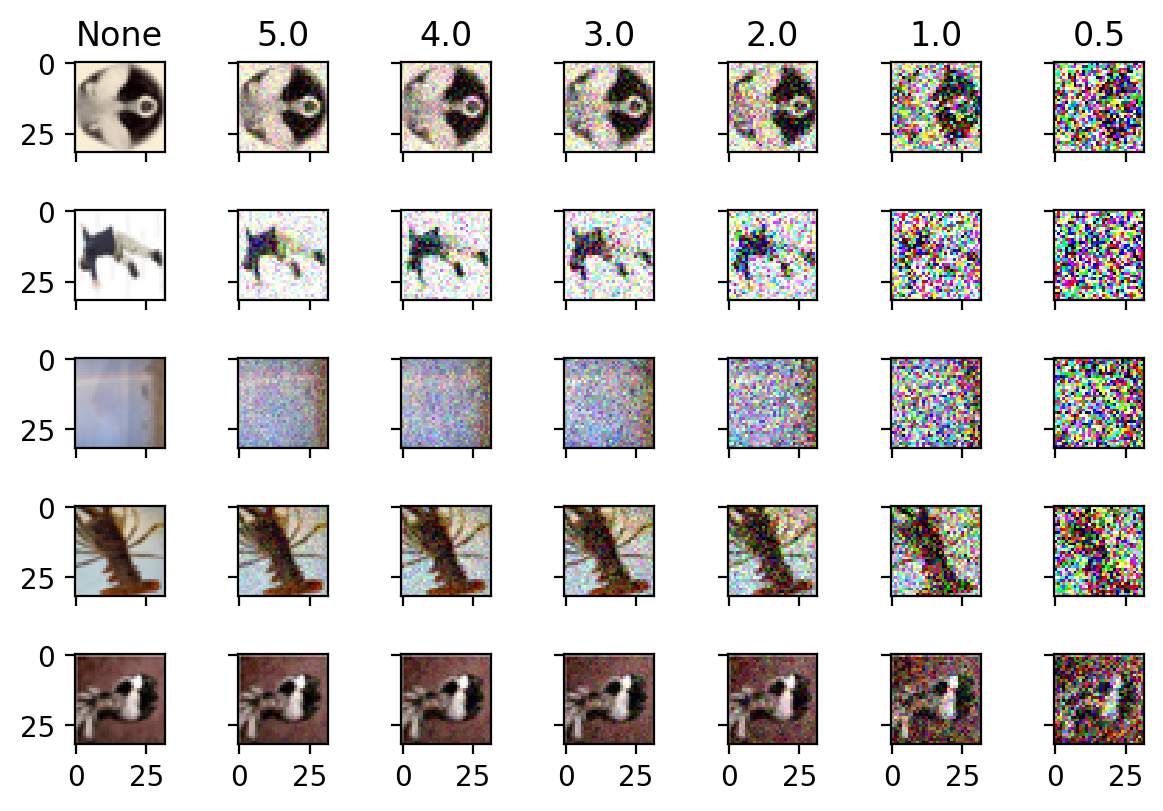

In [115]:
visualize_data(data_loader=data_loaders['val'], num_samples=5, add_noise=True 
               ,noise_snrs=(None, 5.0, 4.0, 3.0, 2.0, 1.0, 0.5), noise_stds=())

==> Starting visualization 


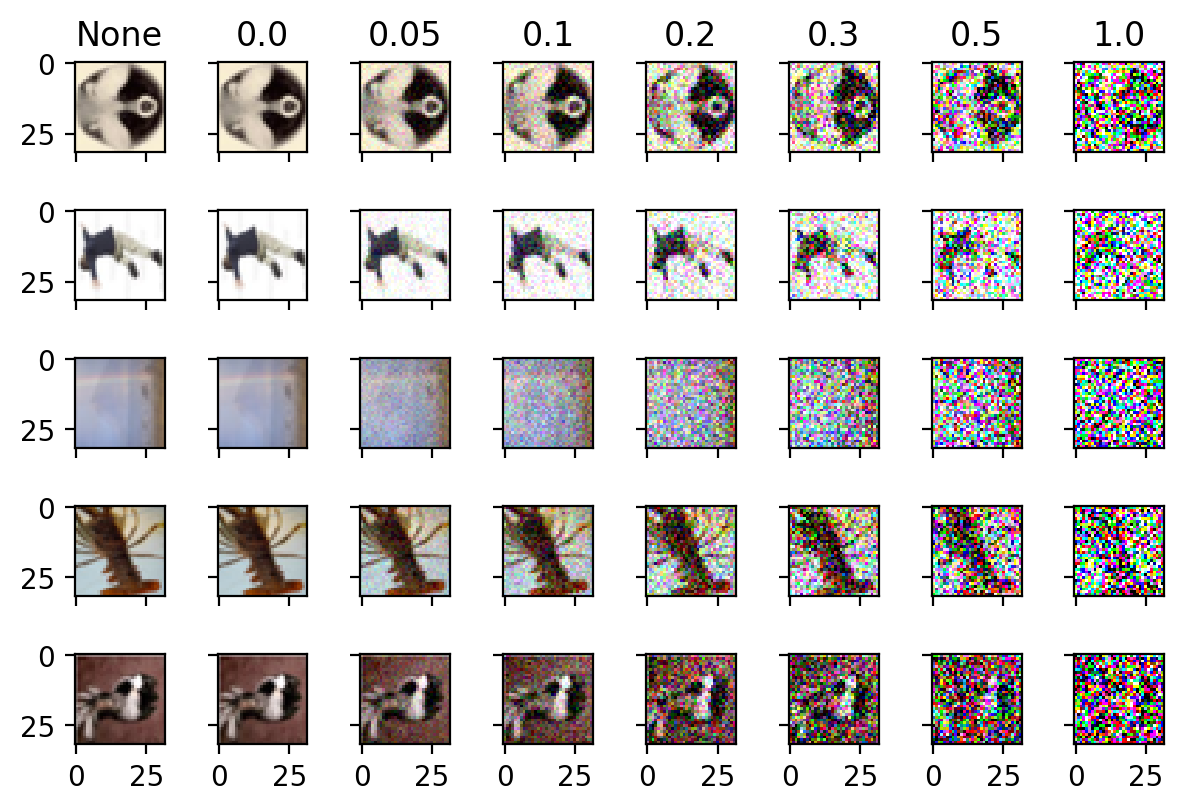

In [118]:
visualize_data(data_loader=data_loaders['val'], num_samples=5, add_noise=True 
               ,noise_stds=(None, 0.0, 0.05, 0.1, 0.2, 0.3, 0.5, 1.0), noise_snrs=())

In [ ]:
visualize_corr_matrix(model=model, data_loader=data_loaders['val'], layer=5, num_samples=2, add_noise=True, load_from_path='checkpoint/ckpt.optimizer_Adam.lr_0.0003.add_noise_True.noise_std_0.1.pth')

# Misc

In [1]:
from bias_transfer.main import *

Connecting anix@datajoint-db.mlcloud.uni-tuebingen.de:3306


In [2]:
config = Config(optimizer="Adam", lr=0.0003, lr_decay=0.5, num_epochs=1, apply_data_augmentation=True,
                    apply_data_normalization=False, transfer=True, freeze=True, reset_linear=False)
fill_tables(config)

In [2]:
TrainedModel().populate(display_progress=True)

  0%|          | 0/1 [00:00<?, ?it/s]


RuntimeError: You have uncommited changes.

bias_transfer
Changed: 	bias_transfer/main.py
Changed: 	notebooks/main.ipynb

Please commit the changes before running populate.


In [3]:
%debug

> /usr/local/lib/python3.7/dist-packages/git/repo/base.py(184)__init__()
    182 
    183         if self.git_dir is None:
--> 184             raise InvalidGitRepositoryError(epath)
    185 
    186         self._bare = False



ipdb>  epath


'/notebooks/bias_transfer'


ipdb>  up


> /notebooks/nnfabrik/nnfabrik/utility/dj_helpers.py(48)check_repo_commit()
     46 
     47 def check_repo_commit(repo_path):
---> 48     repo = Repo(path=repo_path)
     49     g = cmd.Git(repo_path)
     50     origin_url = get_origin_url(g)



ipdb>  up


> /notebooks/nnfabrik/nnfabrik/main.py(290)<listcomp>()
    288     def make(self, key):
    289 
--> 290         commits_info = {name: info for name, info in [check_repo_commit(repo) for repo in config['repos']]}
    291         assert len(commits_info) == len(config['repos'])
    292 



ipdb>  repo


'/notebooks/bias_transfer'


ipdb>  down


> /notebooks/nnfabrik/nnfabrik/utility/dj_helpers.py(48)check_repo_commit()
     46 
     47 def check_repo_commit(repo_path):
---> 48     repo = Repo(path=repo_path)
     49     g = cmd.Git(repo_path)
     50     origin_url = get_origin_url(g)



ipdb>  cmd


<module 'git.cmd' from '/usr/local/lib/python3.7/dist-packages/git/cmd.py'>


ipdb>  down


> /usr/local/lib/python3.7/dist-packages/git/repo/base.py(184)__init__()
    182 
    183         if self.git_dir is None:
--> 184             raise InvalidGitRepositoryError(epath)
    185 
    186         self._bare = False



ipdb>  self.git_dir
ipdb>  epath


'/notebooks/bias_transfer'


ipdb>  os


<module 'os' from '/usr/lib/python3.7/os.py'>


ipdb>  os.getcwd()  


'/notebooks'


ipdb>  os.listdirs()


*** AttributeError: module 'os' has no attribute 'listdirs'


ipdb>  os.listdir()


['c573107ab0de45d4452555a595e5e706.pth.tar', 'data', '18e4b7cec4f3931a524cafedb77f3494.pth_0000.tar', '.ipynb_checkpoints', '1a5655e5ee2717bc0de8f83f002db826.pth.tar', 'main.ipynb', 'models', '18e4b7cec4f3931a524cafedb77f3494.pth.tar', '80d2f9f1aef1345f31693992a8b92111.pth.tar', 'mlutils', 'nnfabrik', 'checkpoint', 'bias_transfer']


ipdb>  os.listdir('bias_transfer')


['data', 'docker-compose.yml', '.history.arnenix', '.gitmodules', '.gitignore', 'notebooks', '.ipynb_checkpoints', '.history.anix', '.env', 'requirements.txt', 'checkpoint', 'setup.py', 'LICENSE', 'bias_transfer']


ipdb>  q


In [2]:
TrainedTransferModel().populate()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Building model..
==> Loading checkpoint..
==> Loading checkpoint..
==> Starting model apply_data_augmentation_True.optimizer_Adam.num_epochs_1.lr_0.0003.lr_decay_0.5.transfer.transfer


Train Epoch 0:   0%|          | 0/352 [00:00<?, ?it/s]

Is connected: True


Eval Epoch 0: 100%|██████████| 40/40 [00:04<00:00,  8.87it/s, acc=50.6, loss=1.62]

==> Saving..


==> Loading checkpoint..


Eval Epoch 999: 100%|██████████| 40/40 [00:04<00:00,  9.18it/s, acc=50.6, loss=1.09]

==> Saving..


==> Loading checkpoint..


Eval Epoch 999: 100%|██████████| 79/79 [00:07<00:00,  9.88it/s, acc=49.5, loss=1.48]

==> Saving..


In [3]:
TrainedTransferModel()

transfer_model_fn name of the model function,transfer_model_hash hash of the model configuration,transfer_dataset_fn name of the dataset loader function,transfer_dataset_hash hash of the configuration object,transfer_trainer_fn name of the Trainer loader function,transfer_trainer_hash hash of the configuration object,transfer_seed Random seed that is passed to the model- and dataset-builder,model_fn name of the model function,model_hash hash of the model configuration,dataset_fn name of the dataset loader function,dataset_hash hash of the configuration object,trainer_fn name of the Trainer loader function,trainer_hash hash of the configuration object,seed Random seed that is passed to the model- and dataset-builder,comment short description,score loss,output trainer object's output,fabrikant_name Name of the contributor that added this entry,trainedmodel_ts UTZ timestamp at time of insertion
bias_transfer.models.resnet.resnet_builder,f899139df5e1059396431415e770c6dd,bias_transfer.dataset.dataset_loader,9755a5aac553850ed406a8c540773aa6,bias_transfer.trainer.trainer,a6d8a7a4b08824d945b21bc9c02c976c,42,bias_transfer.models.resnet.resnet_builder,f899139df5e1059396431415e770c6dd,bias_transfer.dataset.dataset_loader,9755a5aac553850ed406a8c540773aa6,bias_transfer.trainer.trainer,a6d8a7a4b08824d945b21bc9c02c976c,42,apply_data_augmentation_True.optimizer_Adam.num_epochs_1.lr_0.0003.lr_decay_0.5.transfer.resnet50.100.CIFAR100.128,49.45,=BLOB=,Arne Nix,2019-12-23 11:07:18


In [101]:
schema.drop()

Proceed to delete entire schema `anix_nnfabrik_bias_transfer`? [yes, No]:  yes


In [11]:
schema.jobs.drop()